In [1]:
import os
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import json

from utils.dlt import *
from utils.files import FileName
from utils.skeleton_keypoints import *
from utils.motion_visualize_tool import *

In [2]:
with open("cube/subsets.json", "r") as f:
    subsets = json.load(f)

imgpoints = []
for i in ["02", "4"]:
    imgpoints.append(subsets[f"{i}.mp4"])
imgpoints = np.array(imgpoints, dtype=np.float32)

In [3]:
with open("cube/3d_points.json", "r") as f:
    points = json.load(f)
cube_3d = np.array(points["object_point"], dtype=np.float32)
objpoints = np.array([cube_3d for _ in range(len(imgpoints))] , dtype=np.float32)

In [4]:
print(f"imgpoints: {imgpoints.shape}")
print(f"objpoints: {objpoints.shape}")

imgpoints: (2, 8, 2)
objpoints: (2, 8, 3)


In [5]:
cam = 2

p1 = prepare_matrix(imgpoints[0], objpoints[0])
p2 = prepare_matrix(imgpoints[1], objpoints[1])
P = np.array([p1, p2], dtype=np.float32)

cube_array = pose_recon_2c(cam, P, imgpoints)

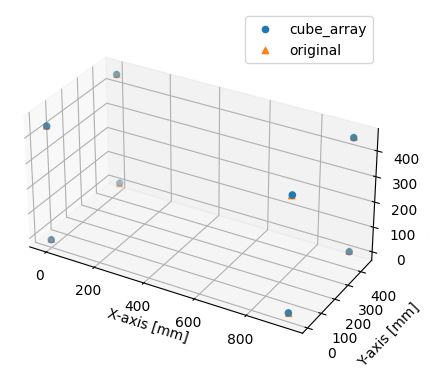

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cube_array[:, 0], cube_array[:, 1], cube_array[:, 2], marker='o', label='cube_array')
ax.scatter(cube_3d[:, 0], cube_3d[:, 1], cube_3d[:, 2], marker='^', label='original')
ax.set_xlabel('X-axis [mm]')
ax.set_ylabel('Y-axis [mm]')
ax.set_zlabel('Z-axis [mm]')
ax.legend()
ax.set_aspect('equal')
plt.show()

In [7]:
data_num = 0

camera_name1 = "0"
camera_name2 = "4"

cam1_dir = f"data/hirasaki_{camera_name1}_{data_num}/"
cam2_dir = f"data/hirasaki_{camera_name2}_{data_num}/"

cam1_position = pd.read_csv(os.path.join(cam1_dir, FileName.position_data), index_col="frame")
cam2_position = pd.read_csv(os.path.join(cam2_dir, FileName.position_data), index_col="frame")

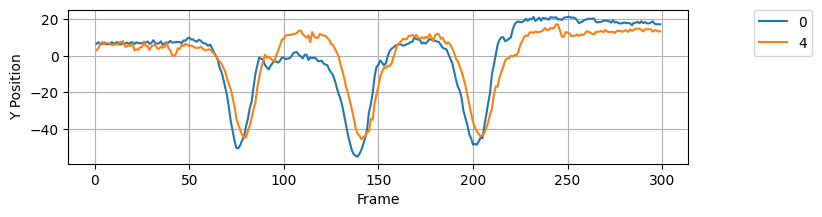

In [8]:
name = "LEFT_ANKLE"

fig, ax = plt.subplots(figsize=(8, 2))
ax.plot(cam1_position.index, cam1_position[f"{name}_y"] - cam1_position[f"{name}_y"].mean(), label=camera_name1)
ax.plot(cam2_position.index, cam2_position[f"{name}_y"] - cam2_position[f"{name}_y"].mean(), label=camera_name2)
ax.grid()
ax.set_xlabel('Frame')
ax.set_ylabel('Y Position')
ax.legend(bbox_to_anchor=(1.2, 1), loc='upper right', borderaxespad=0)
plt.show()

In [9]:
df_camera_sync = pd.read_csv("camera_sync.csv")

toe_off_1 = df_camera_sync["toe_off_0"].iloc[data_num]
toe_off_2 = df_camera_sync["toe_off_4"].iloc[data_num]

delay_1 = toe_off_1 - toe_off_1
delay_2 = toe_off_2 - toe_off_1

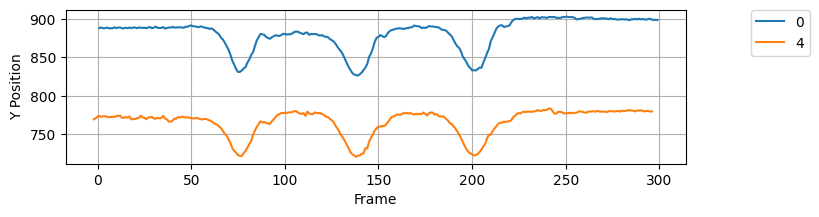

In [10]:
fig, ax = plt.subplots(figsize=(8, 2))
ax.plot(cam1_position.index - delay_1, cam1_position[f"{name}_y"], label=camera_name1)
ax.plot(cam2_position.index - delay_2, cam2_position[f"{name}_y"], label=camera_name2)
ax.grid()
ax.set_xlabel('Frame')
ax.set_ylabel('Y Position')
ax.legend(bbox_to_anchor=(1.2, 1), loc='upper right', borderaxespad=0)
plt.show()

In [11]:
cam1_position["ID"] = cam1_position.index - delay_1
cam2_position["ID"] = cam2_position.index - delay_2

In [12]:
cam1_position = cam1_position.loc[cam1_position["ID"] > 0]
cam2_position = cam2_position.loc[cam2_position["ID"] > 0]

In [13]:
cam1_position.set_index("ID", inplace=True, drop=True)
cam2_position.set_index("ID", inplace=True, drop=True)

In [14]:
min_frame = max(cam1_position.index.min(), cam2_position.index.min())
max_frame = min(cam1_position.index.max(), cam2_position.index.max())

print(min_frame, max_frame)

1.0 296.0


In [15]:
frame = min_frame
cam1_pose = cam1_position.loc[frame].values.reshape(-1, 2)
cam2_pose = cam2_position.loc[frame].values.reshape(-1, 2)
pose = np.array([cam1_pose, cam2_pose], dtype=np.float32)
pose_result = pose_recon_2c(cam, P, pose)

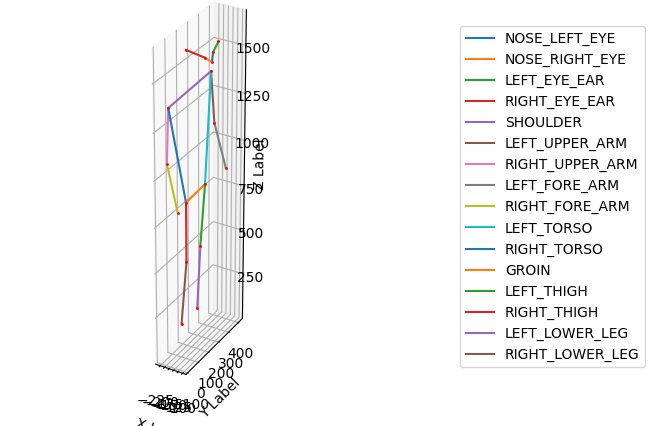

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for key, value in exp_keypoints_connections.items():
    start_idx = value[0]
    end_idx = value[1]
    ax.plot([pose_result[start_idx][0], pose_result[end_idx][0]],
            [pose_result[start_idx][1], pose_result[end_idx][1]],
            [pose_result[start_idx][2], pose_result[end_idx][2]], label=key)
for i in range(len(pose_result)):
    ax.scatter(pose_result[i][0], pose_result[i][1], pose_result[i][2], color='r', s=1)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.legend(loc='center left', bbox_to_anchor=(1.2, 0.5))
ax.set_aspect('equal')
plt.show()

In [17]:
columns = [f"{kpt}_{xyz}" for kpt in exp_keypoints_list for xyz in ["x", "y", "z"]]
position_df = pd.DataFrame(columns=columns)
position_df.index.name = 'frame'

for frame in range(int(min_frame), int(max_frame) + 1):
    cam1_pose = cam1_position.loc[frame].values.reshape(-1, 2)
    cam2_pose = cam2_position.loc[frame].values.reshape(-1, 2)
    pose = np.array([cam1_pose, cam2_pose], dtype=np.float32)
    pose_result = pose_recon_2c(cam, P, pose)
    position_df.loc[frame] = pose_result.ravel()

position_df

,NOSE_x,NOSE_y,NOSE_z,LEFT_EYE_x,LEFT_EYE_y,LEFT_EYE_z,RIGHT_EYE_x,RIGHT_EYE_y,RIGHT_EYE_z,LEFT_EAR_x,...,LEFT_KNEE_z,RIGHT_KNEE_x,RIGHT_KNEE_y,RIGHT_KNEE_z,LEFT_ANKLE_x,LEFT_ANKLE_y,LEFT_ANKLE_z,RIGHT_ANKLE_x,RIGHT_ANKLE_y,RIGHT_ANKLE_z
frame,,,,,,,,,,,,,,,,,,,,,
1,-91.547577,145.297901,1538.164934,-103.111116,173.766778,1572.472876,-110.064354,110.541764,1571.631089,-150.713013,...,461.382276,-207.374935,108.123704,462.405114,-240.128902,267.111809,94.520798,-235.154595,105.518796,95.412822
2,-92.207770,145.149039,1540.074224,-102.326273,176.959962,1574.417088,-109.283418,106.943610,1573.504141,-149.645310,...,466.723236,-203.766521,112.676953,466.063929,-239.350542,271.853246,95.376734,-234.554277,110.239350,96.098471
3,-91.983836,144.639719,1540.285840,-102.131888,177.015738,1573.195090,-109.082496,106.972292,1572.298774,-149.382259,...,465.429549,-204.860921,107.535932,466.300467,-239.086135,269.164419,95.568593,-234.227187,107.517820,96.407929
4,-91.965950,145.932075,1540.180379,-102.107563,178.317637,1573.115749,-109.096428,108.200567,1572.222741,-150.947363,...,465.904698,-203.607018,114.174346,466.803128,-237.700531,267.870087,95.690888,-234.424892,110.147001,95.014308
5,-92.525187,144.980437,1540.042481,-104.065593,180.794471,1572.998756,-109.688690,114.084486,1572.147474,-151.514431,...,464.787565,-204.122298,112.246059,465.738162,-238.295369,268.880356,94.890030,-234.918010,109.650718,95.665384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,4193.760236,-143.631463,1544.050694,4197.859421,-137.017235,1568.994283,4170.252458,-171.488166,1574.844508,4076.720947,...,434.783580,4051.666281,-58.194329,436.811282,4012.827353,163.793516,46.778975,4033.701835,-2.792314,43.633005
293,4190.021973,-144.609659,1544.445157,4195.704533,-140.049493,1569.421152,4169.666833,-172.218258,1573.795263,4076.182089,...,430.444113,4052.634456,-57.506714,435.794083,4013.767504,163.984416,45.716838,4032.982852,-3.573386,44.199646
294,4191.496898,-144.496396,1545.172296,4194.104068,-140.264747,1570.098417,4171.002987,-172.416844,1575.968476,4077.670984,...,429.750320,4051.244122,-58.208304,433.544194,4013.755306,166.427975,45.060348,4032.936284,-2.412531,45.104554


In [18]:
plot_3d_motion_exp(position_df/1000, output_name="camera04.html")